In [ ]:
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
import os

2024-05-28 00:17:08.147812: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 00:17:08.147915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 00:17:08.263796: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
""" Hyperparameters """
hp = {}
hp["image_size"] = 256
hp["num_channels"] = 3
hp["patch_size"] = 32
hp["num_patches"] = int(hp["image_size"]**2) // (hp["patch_size"]**2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"]*hp["patch_size"]*hp["num_channels"])

hp["batch_size"] = 64
hp["lr"] = 1e-4
hp["num_epochs"] = 250
hp["num_classes"] = 2
hp["class_names"] = ["benign", "malignant"]

hp["num_layers"] = 6
hp["hidden_dim"] = 256
hp["mlp_dim"] = 768
hp["num_heads"] = 8
hp["dropout_rate"] = 0.1

In [ ]:
hp

{'image_size': 256,
 'num_channels': 3,
 'patch_size': 32,
 'num_patches': 64,
 'flat_patches_shape': (64, 3072),
 'batch_size': 64,
 'lr': 0.0001,
 'num_epochs': 250,
 'num_classes': 2,
 'class_names': ['benign', 'malignant'],
 'num_layers': 6,
 'hidden_dim': 256,
 'mlp_dim': 768,
 'num_heads': 8,
 'dropout_rate': 0.1}

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import glob as gb
import cv2
import pandas as pd
#loading data and resize it and collect it in one folder

trainpath = r'D:/Research/SkincancerMelanoma_dataset/train'
new_size=256
X_train = []
y_train = []
for folder in  os.listdir(trainpath ) :
    print( 'folder name is : ', folder)
    files = gb.glob(pathname= str( trainpath  + folder + '/*.jpg'))
    print( 'numbers of images in folder are : ', len(files))
    print(' start reading images')
    for file in files:
        image_class = {'benign': 0, 'malignant': 1 }
        orignal_image = cv2.imread(file)
        image = cv2.cvtColor(orignal_image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(image , (new_size,new_size))
        resized_image = resized_image /255.0
        X_train.append(resized_image)
        y_train.append(image_class[folder])
    print('image reading ...finished')
print('--------------------------------------------------')
#check items in X_test
print("items in X_train is:       ",len(X_train) , " items")
print("items in y_train is:       ",len(y_train) , " items")

folder name is :  benign
numbers of images in folder are :  1440
 start reading images
image reading ...finished
folder name is :  malignant
numbers of images in folder are :  1197
 start reading images
image reading ...finished
--------------------------------------------------
items in X_train is:        2637  items
items in y_train is:        2637  items


In [ ]:
X_train=np.array( X_train)
y_train=np.array(y_train)

In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet import ResNet50

class ClassToken(Layer):
    def __init__(self,):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(1, 1, input_shape[-1]), dtype="float32"),
            trainable=True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)

        return cls

def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x

def ResNet50ViT(cf):
    """ Input """
    inputs = Input((cf["image_size"], cf["image_size"], cf["num_channels"])) ## (None, 512, 512, 3)

    """ Pre-trained Resnet50 """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    output = resnet50.output ## (None, 16, 16, 2048)
    #print(output.shape)

    initial_projection = Conv2D(
    cf["hidden_dim"],
    kernel_size=1,  # 1x1 kernel for channel projection
    padding="same"
                )(output)

    patch_embed = Conv2D(
                cf["hidden_dim"],
                kernel_size=cf["patch_size"],
                padding="same"
            )(initial_projection)

    _, h, w, f = patch_embed.shape
    patch_embed = Reshape((h*w, f))(patch_embed) ## (None, 256, 768)


    """ Position Embeddings """
    positions = tf.range(start=0, limit=cf["num_patches"], delta=1) ## (256,)
    pos_embed = Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions)

    """ Patch + Position Embeddings """
    embed = patch_embed + pos_embed ## (None, 256, 768)

    """ Adding Class Token """
    token = ClassToken()(embed)
    x = Concatenate(axis=1)([token, embed]) ## (None, 257, 768)

    """ Transformer Encoder """
    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    x = LayerNormalization()(x)
    x = x[:, 0, :]
    x = Dense(cf["num_classes"], activation="softmax")(x)

    model = Model(inputs, x)
    return model



model = ResNet50ViT(hp)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(None, 8, 8, 2048)


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 106,215,298 (405.18 MB)

 Trainable params: 106,162,178 (404.98 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(hp["lr"], clipvalue=1.0),
        metrics=["acc"]
    )

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

create_dir("files")

model_path = os.path.join("files", "model.keras")
csv_path = os.path.join("files", "log.csv")

In [ ]:
callbacks = [
        ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, min_lr=1e-10, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=False),
    ]

In [ ]:
history = model.fit(
        x=X_train,
        y=y_train,
        epochs=hp["num_epochs"],
        validation_split=0.1,
        callbacks=callbacks,
    verbose=1
    )

Epoch 1/250


I0000 00:00:1716855701.684179      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716855701.819802      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.7507 - loss: 0.9530   

W0000 00:00:1716855801.123481      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.77228, saving model to files/model.keras


W0000 00:00:1716855817.215195      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - acc: 0.7516 - loss: 0.9475 - val_acc: 0.5000 - val_loss: 0.7723 - learning_rate: 1.0000e-04
Epoch 2/250
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - acc: 0.9246 - loss: 0.1818
Epoch 2: val_loss did not improve from 0.77228
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 470ms/step - acc: 0.9247 - loss: 0.1817 - val_acc: 0.5000 - val_loss: 2.6234 - learning_rate: 1.0000e-04
Epoch 3/250
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - acc: 0.9494 - loss: 0.1366
Epoch 3: val_loss did not improve from 0.77228
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 478ms/step - acc: 0.9494 - loss: 0.1367 - val_acc: 0.5000 - val_loss: 1.3992 - learning_rate: 1.0000e-04
Epoch 4/250
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - acc: 0.9724 - loss: 0.0829
Epoch 4: val_loss did not improve from 0.77228
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 486ms/step - acc: 0.9725 - loss: 0.0828 - val_acc: 0.5000 - val_loss: 3.0696 - learning_rate: 1.0000e-04
Epoch 5/250
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - acc: 0.9818 - lo

In [ ]:
#plotting training values
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)


<Figure size 640x480 with 0 Axes>

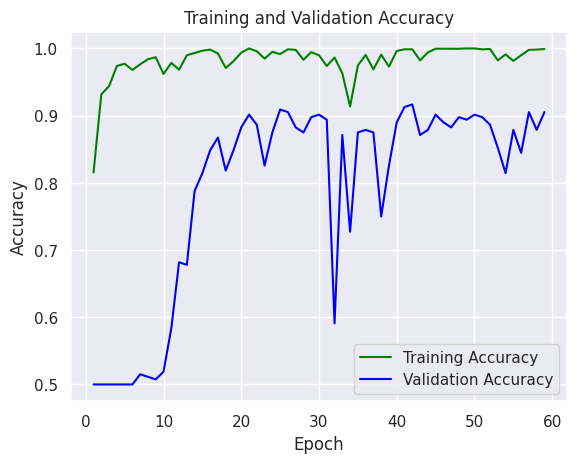

<Figure size 640x480 with 0 Axes>

In [ ]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

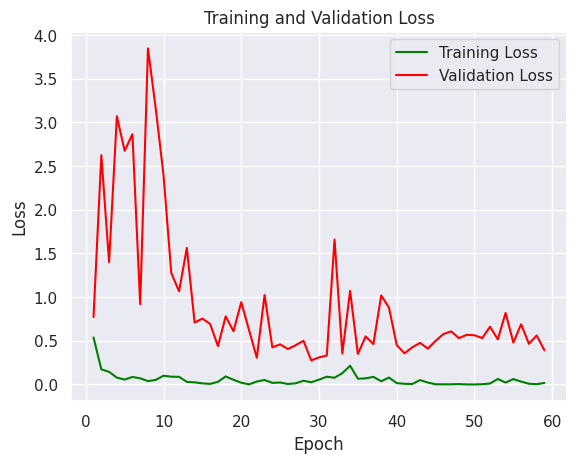

In [ ]:
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
#loading data and resize it and collect it in one folder

testpath = r'D:/Research/SkincancerMelanoma_dataset/test'
new_size=256
X_test = []
y_test = []
for folder in  os.listdir(testpath ) :
    print( 'folder name is : ', folder)
    files = gb.glob(pathname= str( testpath  + folder + '/*.jpg'))
    print( 'numbers of images in folder are : ', len(files))
    print(' start reading images')
    for file in files:
        image_class = {'benign': 0, 'malignant': 1 }
        orignal_image = cv2.imread(file)
        image = cv2.cvtColor(orignal_image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(image , (new_size,new_size))
        resized_image = resized_image /255.0
        X_test.append(resized_image)
        y_test.append(image_class[folder])
    print('image reading ...finished')
print('--------------------------------------------------')

print("items in X_test is:       ",len(X_test) , " items")
print("items in y_test is:       ",len(y_test) , " items")

folder name is :  benign
numbers of images in folder are :  360
 start reading images
image reading ...finished
folder name is :  malignant
numbers of images in folder are :  300
 start reading images
image reading ...finished
--------------------------------------------------
items in X_test is:        660  items
items in y_test is:        660  items


In [ ]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
model.evaluate(X_test,y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 637ms/step - acc: 0.8935 - loss: 0.5561


W0000 00:00:1716858080.395986      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.4546070992946625, 0.9090909361839294]

In [ ]:
y_pred = model.predict(X_test).argmax(axis=-1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 425ms/step


W0000 00:00:1716858096.180488      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

      benign       0.93      0.90      0.92       360
   malignant       0.88      0.92      0.90       300

    accuracy                           0.91       660
   macro avg       0.91      0.91      0.91       660
weighted avg       0.91      0.91      0.91       660



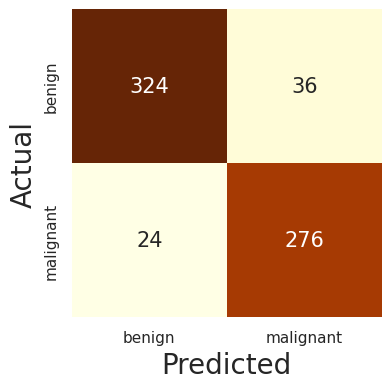

In [ ]:
from sklearn.metrics  import classification_report ,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['benign', 'malignant']
report = classification_report(y_test, y_pred, target_names=target_names, digits=2)
print(report)

disp = confusion_matrix(y_test, y_pred)
disp.astype('int')
pd.options.display.float_format='{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)
# plt.figure(figsize=(10,7))
fig, ax = plt.subplots(figsize=(4,4))
sns.set(font_scale=1.5) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size":15},ax=ax, cmap="YlOrBr", fmt='g',cbar=False) #font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()

In [ ]:
def test_image(path_image,model,classes):
    orignal_image = cv2.imread(path_image)
    image = cv2.cvtColor(orignal_image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image , (new_size,new_size))
    image = image /255.0
    image = np.expand_dims(image,axis=0)

    return classes[model.predict(image)[0].argmax(axis=-1)]

In [ ]:
image_path = r'D:/Research/SkincancerMelanoma_dataset/test/benign/11.jpg'
test_image(path_image= image_path ,model = model,classes = ['benign', 'malignant'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


'benign'

In [ ]:
image_path = r'D:/Research/SkincancerMelanoma_dataset/test/malignant/3.jpg'
test_image(path_image= image_path ,model = model,classes = ['benign', 'malignant'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


'malignant'